## Write forcefield file


In [1]:
%%writefile Si.tersoff
# DATE: 2007-10-25 CONTRIBUTOR: Aidan Thompson, athomps@sandia.gov CITATION: Tersoff, Phys Rev B, 37, 6991 (1988)

# Tersoff parameters for various elements and mixtures
# multiple entries can be added to this file, LAMMPS reads the ones it needs
# these entries are in LAMMPS "metal" units:
#   A,B = eV; lambda1,lambda2,lambda3 = 1/Angstroms; R,D = Angstroms
#   other quantities are unitless

# This is the Si parameterization from a particular Tersoff paper:
# J. Tersoff, PRB, 37, 6991 (1988)
# See the SiCGe.tersoff file for different Si variants.

# format of a single entry (one or more lines):
#   element 1, element 2, element 3,
#   m, gamma, lambda3, c, d, costheta0, n, beta, lambda2, B, R, D, lambda1, A

Si     Si      Si        3.0 1.0 0.0 1.0039e5 16.217 -0.59825 0.78734 1.1000e-6  1.7322  471.18    2.85    0.15   2.4799  1830.8

Overwriting Si.tersoff


In [11]:
import lammps
from ase.calculators.espresso import Espresso

## Thermal transport simulation for silicon-bulk

In [15]:
from ase.build import bulk
from ase.calculators.lammpslib import LAMMPSlib
from kaldo.forceconstants import ForceConstants
import numpy as np

# We start from the atoms object
atoms = bulk('Si', 'diamond', a=5.432)

# Config super cell and calculator input
supercell = np.array([3, 3, 3])
lammps_inputs = {
      'lmpcmds': [
          'pair_style tersoff',
          'pair_coeff * * Si.tersoff Si'],

      'log_file': 'lammps-si-bulk.log',
      'keep_alive':True}

# Create a finite difference object
forceconstants_config  = {'atoms':atoms,'supercell': supercell,'folder':'fd'}
forceconstants = ForceConstants(**forceconstants_config)

# Compute 2nd and 3rd IFCs with the defined calculators
forceconstants.second.calculate(LAMMPSlib(**lammps_inputs), delta_shift=1e-3)
forceconstants.third.calculate(LAMMPSlib(**lammps_inputs), delta_shift=1e-3)
# forceconstants.second.calculate(calculator=Espresso(**input))

2025-10-05 00:35:01,321 - kaldo - WARNING - Directly use ForceConstants to load data from folder is discouraged with limit                             functionalities. Please use ForceConstants.from_folder for more options.
2025-10-05 00:35:01,344 - kaldo - INFO - Reading stored second
2025-10-05 00:35:01,382 - kaldo - INFO - Reading stored third


### Create phonons object


In [4]:
from kaldo.phonons import Phonons

# Define k-point grids, temperature
# and the assumption for the
# phonon poluation (i.e classical vs. quantum)
k = 7
kpts = [k, k, k]
temperature = 300
is_classic = False
k_label = str(k) + '_' + str(k) + '_' + str(k)

# Create a phonon object
phonons = Phonons(forceconstants=forceconstants,
                kpts=kpts,
                is_classic=is_classic,
                temperature=temperature,
                folder='si-bulk-ald-' + k_label,
                storage='numpy')

### Calculate conductivities for infinite-size sample


In [5]:
from kaldo.conductivity import Conductivity

# Calculate conductivity  with direct inversion approach (inverse)
print('\n')
inv_cond_matrix = (Conductivity(phonons=phonons, method='inverse').conductivity.sum(axis=0))
print('Inverse conductivity (W/mK): %.3f'%(np.mean(np.diag(inv_cond_matrix))))
print(inv_cond_matrix)

# Calculate conductivity  with  relaxation time approximation (rta)
print('\n')
rta_cond_matrix = Conductivity(phonons=phonons, m(rta_cond_matrix))))
print(rta_cond_matrix)
# Calculate conductivity  with  self-consistent approach (sc)

print('\n')
sc_cond_matrix = Conductivity(phonons=phonons, method='sc',n_iterations=20).conductivity.sum(axis=0)
print('Self-consistent conductivity (W/mK): %.3f'%(np.mean(np.diag(sc_cond_matrix))))
print(sc_cond_matrix)



2025-10-05 00:04:10,556 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/inverse/300/quantum/conductivity
Inverse conductivity (W/mK): 290.621
[[291.77285023   1.99134493   0.50237847]
 [  2.0517228  288.27849881  -1.2275711 ]
 [  0.49791262  -1.23967582 291.81264541]]


2025-10-05 00:04:10,558 - kaldo - WARNING - rta method is specified, but n_iterations is not specified to be 0. Please check your setup. Now, n_iterations is reset to 0.
2025-10-05 00:04:10,668 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/rta/300/quantum/conductivity
Rta conductivity (W/mK): 258.085
[[ 2.59117988e+02  1.32946629e+00  1.66956668e-02]
 [ 1.32946629e+00  2.55935090e+02 -1.46320376e+00]
 [ 1.66956668e-02 -1.46320376e+00  2.59201298e+02]]


2025-10-05 00:04:10,781 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/sc/300/quantum/conductivity
Self-consistent conductivity (W/mK): 290.621
[[291.77285022   1.99134499   0.50237837]
 [  2.05172268 288.27849766  -1.22757132]
 [  0.49791261  -1.2396759  291.812

### Visualize harmonic properties using built-in plotter


C:\Users\allen\miniconda3\envs\phys449\Lib\site-packages\seekpath\hpkot\__init__.py:172: DeprecationWarning: dict interface is deprecated. Use attribute interface instead
  conv_lattice = dataset["std_lattice"]
C:\Users\allen\miniconda3\envs\phys449\Lib\site-packages\kaldo\observables\harmonic_with_q.py:256: RuntimeWarning: invalid value encountered in sqrt
  inverse_sqrt_freq = tf.cast(tf.convert_to_tensor(1 / np.sqrt(frequency)), tf.complex128)


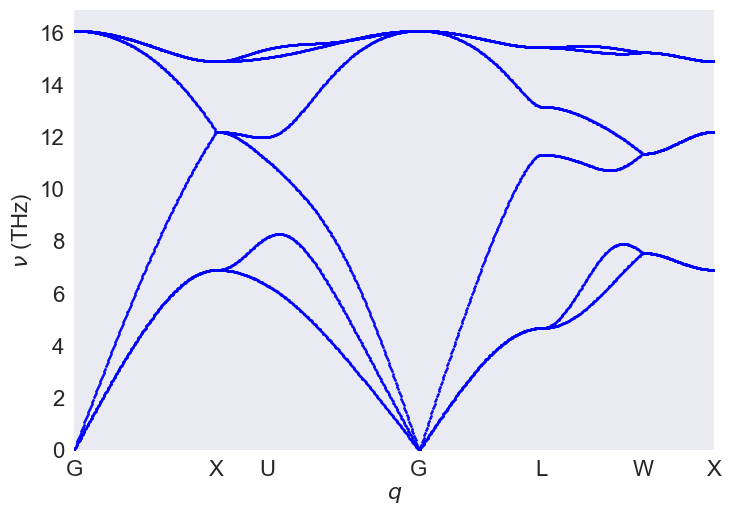

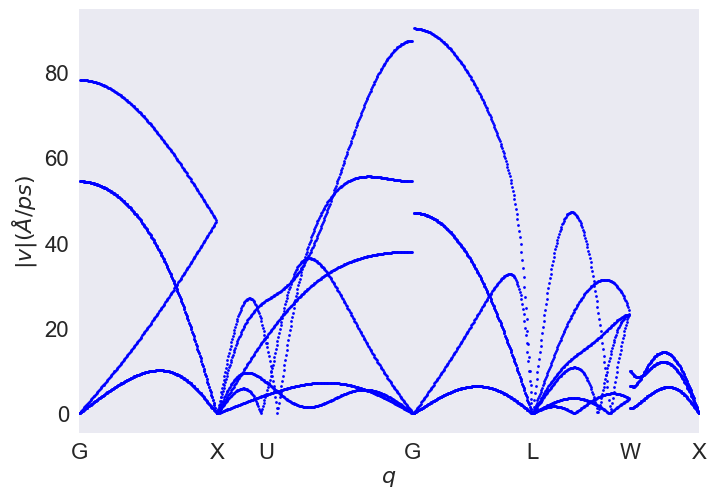

In [6]:
import kaldo.controllers.plotter as plotter
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

# Plot dispersion relation and group velocity in each direction
plotter.plot_dispersion(phonons,n_k_points=int(k_label))
print('\n')

### Access and visualize properties calculated during simulations

2025-10-05 00:04:19,923 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency
2025-10-05 00:04:19,941 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity




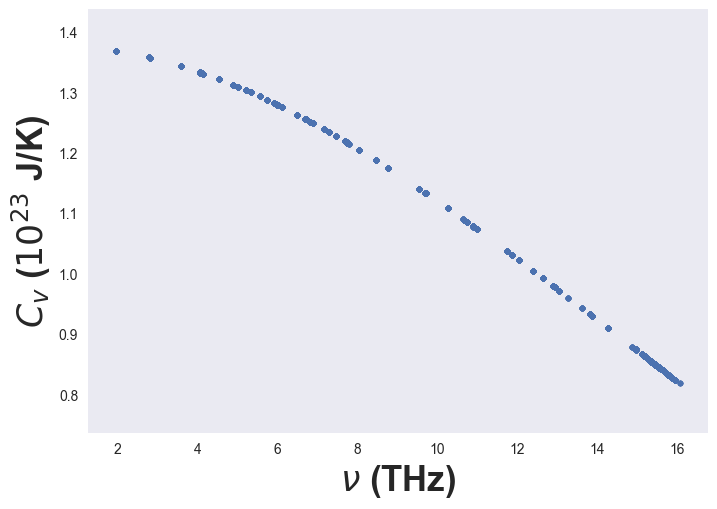

2025-10-05 00:04:20,076 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth




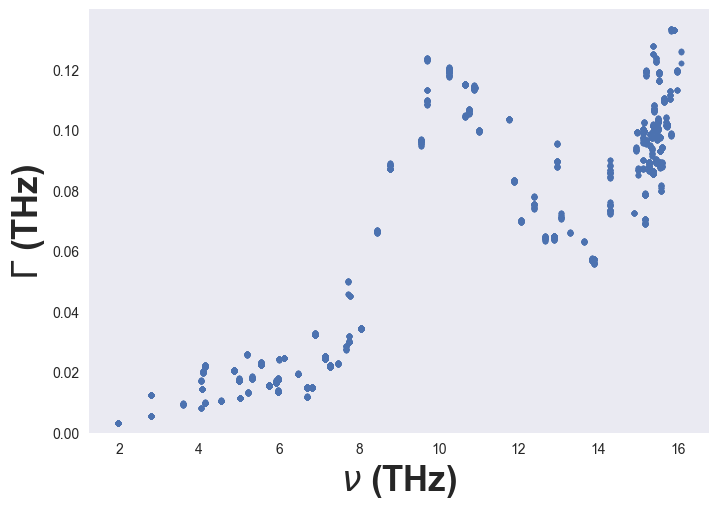



2025-10-05 00:04:20,172 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/300/quantum/phase_space not found in numpy format, calculating phase_space
2025-10-05 00:04:20,185 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/_ps_and_gamma
2025-10-05 00:04:20,187 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/300/quantum/phase_space stored
2025-10-05 00:04:20,213 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/phase_space
2025-10-05 00:04:20,215 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/phase_space


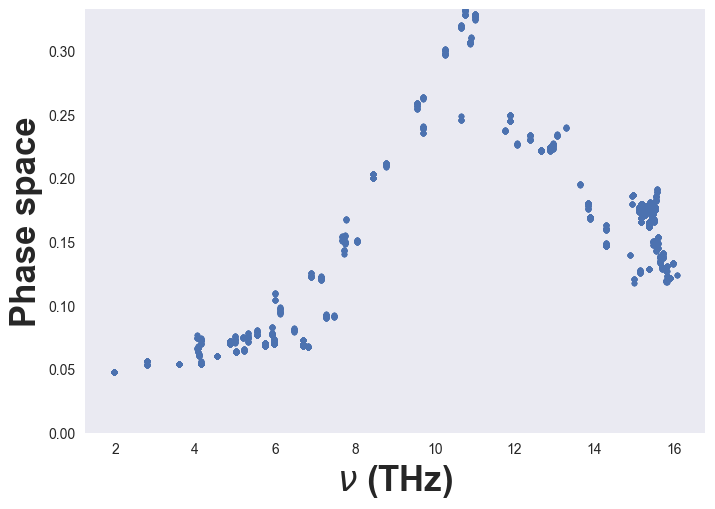

In [7]:
# Direct access to properties
# calculated during the simulation

# Plot heat capacity vs frequency
freq_full = phonons.frequency.flatten(order='C')
cv_1d = phonons.heat_capacity.flatten(order='C')[3:]

print('\n')
plt.figure()
plt.scatter(freq_full[3:],1e23*cv_1d,s=15)
plt.ylabel (r"$C_{v}$ ($10^{23}$ J/K)", fontsize=25, fontweight='bold')
plt.xlabel ("$\\nu$ (THz)", fontsize=25, fontweight='bold')
plt.ylim(0.9*1e23*cv_1d[cv_1d>0].min(),
         1.05*1e23*cv_1d.max())
plt.grid()
plt.show()

# Plot phonon bandwidth vs frequency
band_width_flatten = phonons.bandwidth.flatten(order='C')
freq = freq_full[band_width_flatten!=0]

print('\n')
plt.figure()
plt.scatter(freq,band_width_flatten[band_width_flatten!=0] ,s=15)
plt.ylabel (r"$\Gamma$ (THz)", fontsize=25, fontweight='bold')
plt.xlabel ("$\\nu$ (THz)", fontsize=25, fontweight='bold')
plt.ylim(0.95*band_width_flatten .min(), 1.05*band_width_flatten .max())
plt.grid()
plt.show()

# Plot phase space vs frequency
print('\n')
plt.figure()
plt.scatter(freq_full[3:],phonons.phase_space.flatten(order='C')[3:],s=15)
plt.ylabel ("Phase space", fontsize=25, fontweight='bold')
plt.xlabel ("$\\nu$ (THz)", fontsize=25, fontweight='bold')
plt.ylim(phonons.phase_space.min(), phonons.phase_space.max())
plt.grid()
plt.show()

### Calculate and visualize $\kappa_{per \ mode}$ and $\kappa_{cum}$

In [8]:
def cumulative_cond_cal(freq,full_cond,n_phonons):

  conductivity = np.einsum('maa->m', 1/3 * full_cond)
  conductivity = conductivity.reshape(n_phonons)
  cumulative_cond = np.zeros_like(conductivity)
  freq_reshaped = freq.reshape(n_phonons)

  for mu in range(cumulative_cond.size):
      single_cumulative_cond = conductivity[(freq_reshaped < freq_reshaped[mu])].sum()
      cumulative_cond[mu] = single_cumulative_cond

  return cumulative_cond

2025-10-05 00:04:20,314 - kaldo - WARNING - rta method is specified, but n_iterations is not specified to be 0. Please check your setup. Now, n_iterations is reset to 0.
2025-10-05 00:04:20,329 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/rta/300/quantum/conductivity
2025-10-05 00:04:20,343 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/inverse/300/quantum/conductivity
2025-10-05 00:04:20,361 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/sc/300/quantum/conductivity
2025-10-05 00:04:20,363 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency
2025-10-05 00:04:20,365 - kaldo - WARNING - rta method is specified, but n_iterations is not specified to be 0. Please check your setup. Now, n_iterations is reset to 0.
2025-10-05 00:04:20,385 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/rta/300/quantum/conductivity
2025-10-05 00:04:20,408 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency
2025-10-05 00:04:20,424 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/sc/300/qua

C:\Users\allen\miniconda3\envs\phys449\Lib\site-packages\kaldo\controllers\dirac_kernel.py:26: RuntimeWarning: invalid value encountered in divide
  lorentzian = 1 / np.pi * 1 / 2 * sigma / (delta_omega ** 2 + (sigma / 2) ** 2)


2025-10-05 00:04:30,056 - kaldo - INFO - Conductivity calculated




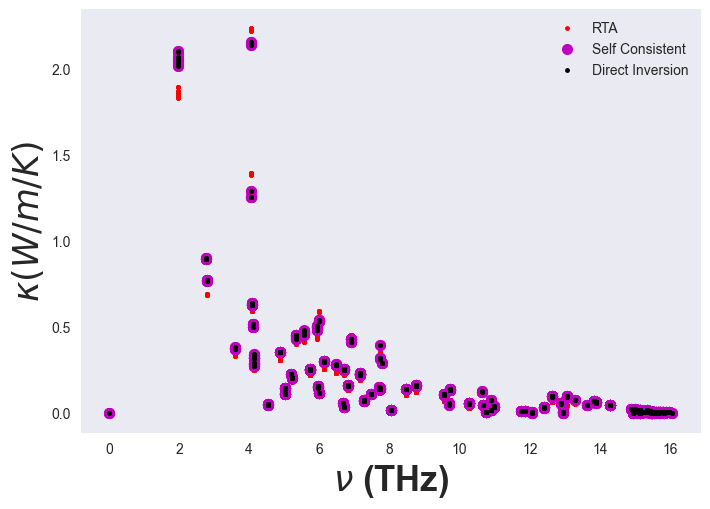

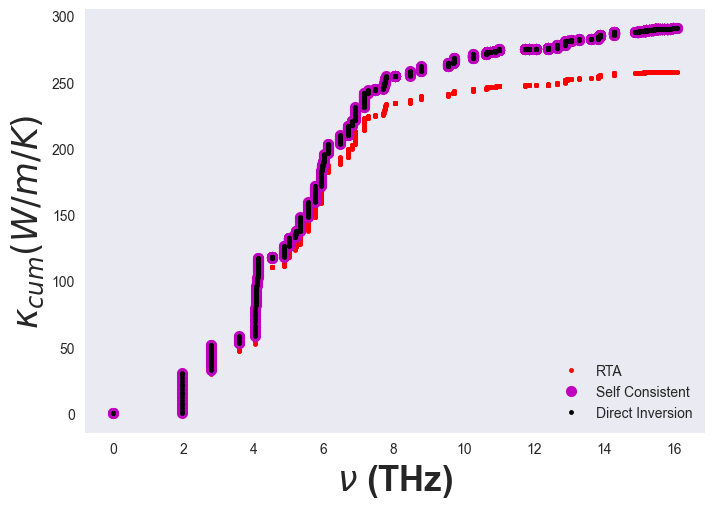

In [9]:
# Compute conductivity with per phonon mode basis using different methods
kappa_rta_per_mode = np.einsum('maa->m',1/3*Conductivity(phonons=phonons, method='rta').conductivity)
kappa_inv_per_mode = np.einsum('maa->m',1/3*Conductivity(phonons=phonons, method='inverse').conductivity)
kappa_sc_per_mode = np.einsum('maa->m',1/3*Conductivity(phonons=phonons, method='sc',n_iterations=20).conductivity)

# Compute cumulative conductivity by frequency using different methods
kappa_rta_cum_freq = cumulative_cond_cal(phonons.frequency,Conductivity(phonons=phonons, method='rta').conductivity,phonons.n_phonons)
kappa_sc_cum_freq = cumulative_cond_cal(phonons.frequency,Conductivity(phonons=phonons, method='sc',n_iterations=20).conductivity,phonons.n_phonons)
kappa_inv_cum_freq = cumulative_cond_cal(phonons.frequency,Conductivity(phonons=phonons, method='inverse').conductivity,phonons.n_phonons)
kappa_qhgk_cum_freq = cumulative_cond_cal(phonons.frequency,Conductivity(phonons=phonons, method='qhgk').conductivity,phonons.n_phonons)
print('\n')

# Visualize the cumulative conductivity vs frequency
plt.figure()
plt.plot(freq_full,kappa_rta_per_mode,'r.',label='RTA')
plt.plot(freq_full,kappa_sc_per_mode,'mo',label='Self Consistent',ms=8)
plt.plot(freq_full,kappa_inv_per_mode,'k.',label='Direct Inversion')
plt.xlabel ("$\\nu$ (THz)", fontsize=25, fontweight='bold')
plt.ylabel(r'$\kappa(W/m/K)$', fontsize=25, fontweight='bold')
plt.legend(loc=1,frameon=False)
plt.grid()
plt.show()
print('\n')

# Visualize the cumulative conductivity vs frequency
plt.figure()
plt.plot(freq_full,kappa_rta_cum_freq,'r.',label='RTA')
plt.plot(freq_full,kappa_sc_cum_freq,'mo',label='Self Consistent',ms=8)
plt.plot(freq_full,kappa_inv_cum_freq,'k.',label='Direct Inversion')
plt.xlabel ("$\\nu$ (THz)", fontsize=25, fontweight='bold')
plt.ylabel(r'$\kappa_{cum}(W/m/K)$', fontsize=25, fontweight='bold')
plt.legend(loc=4,frameon=False)
plt.grid()
plt.show()